# 神经网络：线性回归

实验内容：

使用advertising-dataset广告预测数据集，以TV, Radio, Newspaper三种特征作为模型的输入，Sales作为模型的输出
1. 学会梯度下降的基本思想
2. 学会使用梯度下降求解线性回归
3. 了解归一化处理的作用

## 线性回归

<img src="https://davidham3.github.io/blog/2018/09/11/logistic-regression/Fig0.png" width=300>

我们来完成最简单的线性回归，上图是一个最简单的神经网络，一个输入层，一个输出层，没有激活函数。  
我们记输入为$X \in \mathbb{R}^{n \times m}$，输出为$Z \in \mathbb{R}^{n}$。输入包含了$n$个样本，$m$个特征，输出是对这$n$个样本的预测值。  
输入层到输出层的权重和偏置，我们记为$W \in \mathbb{R}^{m}$和$b \in \mathbb{R}$。  
输出层没有激活函数，所以上面的神经网络的前向传播过程写为：

$$
Z = XW + b
$$

**注意：这里我们其实是做了广播，将$b$复制了$n-1$份后拼接成了维数为$n$的向量。**

我们使用均方误差作为模型的损失函数

$$
\mathrm{loss}(y, \hat{y}) = \frac{1}{n} \sum^n_{i=1}(y_i - \hat{y_i})^2
$$

我们通过调整参数$W$和$b$来降低均方误差，或者说是以降低均方误差为目标，学习参数$W$和参数$b$。当均方误差下降的时候，我们认为当前的模型的预测值$Z$与真值$y$越来越接近，也就是说模型正在学习如何让自己的预测值变得更准确。

在前面的课程中，我们已经学习了这种线性回归模型可以使用最小二乘法求解，最小二乘法在求解数据量较小的问题的时候很有效，但是最小二乘法的时间复杂度很高，一旦数据量变大，效率很低，实际应用中我们会使用梯度下降等基于梯度的优化算法来求解参数$W$和参数$b$。

## 梯度下降

梯度下降是一种常用的优化算法，通俗来说就是计算出参数的梯度（损失函数对参数的偏导数的导数值），然后将参数减去参数的梯度乘以一个很小的数（下面的公式），来改变参数，然后重新计算损失函数，再次计算梯度，再次进行调整，通过一定次数的迭代，参数就会收敛到最优点附近。

在我们的这个线性回归问题中，我们的参数是$W$和$b$，使用以下的策略更新参数：

$$
W := W - \alpha \frac{\partial \mathrm{loss}}{\partial W}
$$

$$
b := b - \alpha \frac{\partial \mathrm{loss}}{\partial b}
$$

其中，$\alpha$ 是学习率，一般设置为0.1，0.01等。

接下来我们会求解损失函数对参数的偏导数。

损失函数MSE记为：

$$
\mathrm{loss}(y, Z) = \frac{1}{n} \sum^n_{i = 1} (y_i - Z_i)^2
$$

其中，$Z \in \mathbb{R}^{n}$是我们的预测值，也就是神经网络输出层的输出值。这里我们有$n$个样本，实际上是将$n$个样本的预测值与他们的真值相减，取平方后加和。

我们计算损失函数对参数$W$的偏导数，根据链式法则，可以将偏导数拆成两项，分别求解后相乘：

**这里我们以矩阵的形式写出推导过程，感兴趣的同学可以尝试使用单个样本进行推导，然后推广到矩阵形式**

$$\begin{aligned}
\frac{\partial \mathrm{loss}}{\partial W} &= \frac{\partial \mathrm{loss}}{\partial Z} \frac{\partial Z}{\partial W}\\
&= - \frac{2}{n} X^\mathrm{T} (y - Z)\\
&= \frac{2}{n} X^\mathrm{T} (Z - y)
\end{aligned}$$

同理，求解损失函数对参数$b$的偏导数:

$$\begin{aligned}
\frac{\partial \mathrm{loss}}{\partial b} &= \frac{\partial \mathrm{loss}}{\partial Z} \frac{\partial Z}{\partial b}\\
&= - \frac{2}{n} \sum^n_{i=1}(y_i - Z_i)\\
&= \frac{2}{n} \sum^n_{i=1}(Z_i - y_i)
\end{aligned}$$

其中，$\frac{\partial \mathrm{loss}}{\partial W} \in \mathbb{R}^{m}$，$\frac{\partial \mathrm{loss}}{\partial b} \in \mathbb{R}$，求解得到的梯度的维度与参数一致。

完成上式两个梯度的计算后，就可以使用梯度下降法对参数进行更新了。

训练神经网络的基本思路：

1. 首先对参数进行初始化，对参数进行随机初始化（也就是取随机值）
2. 将样本输入神经网络，计算神经网络预测值 $Z$
3. 计算损失值MSE
4. 通过 $Z$ 和 $y$ ，以及 $X$ ，计算参数的梯度
5. 使用梯度下降更新参数
6. 循环1-5步，**在反复迭代的过程中可以看到损失值不断减小的现象，如果没有下降说明出了问题**

接下来我们来实现这个最简单的神经网络。

## 1. 导入数据

使用advertising-dataset广告预测数据，选3列作为特征

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 读取数据
data = pd.read_csv('./data/advertising/advertising.csv')

# 使用这3列作为特征
features = ['TV', 'Radio', 'Newspaper']
target = 'Sales'
data = data[features + [target]]

## 2. 数据预处理

40%做测试集，60%做训练集

In [2]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(data[features], data[target], test_size = 0.4, random_state = 32)

训练集120个样本，3个特征，测试集80个样本，3个特征

In [3]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((120, 3), (120,), (80, 3), (80,))

## 3. 参数初始化

这里，我们要初始化参数$\mathbf{w}$和$b$，其中$\mathbf{w} \in \mathbb{R}^m$，$b \in \mathbb{R}$，初始化的策略是将$\mathbf{w}$初始化成一个随机数矩阵，参数$b$为0。

In [4]:
def initialize(m):
    '''
    参数初始化，将W初始化成一个随机向量，b是一个长度为1的向量
    
    Parameters
    ----------
    m: int, 特征数
    
    Returns
    ----------
    W: np.ndarray, shape = (m, ), 参数W
    
    b: np.ndarray, shape = (1, ), 参数b
    
    '''
    
    # 指定随机种子，这样生成的随机数就是固定的了，这样就可以与下面的测试样例进行比对
    np.random.seed(32)
    
    W = np.random.normal(size = (m, )) * 0.01
    
    b = np.zeros((1, ))
    
    return W, b

## 4. 前向传播

这里，我们要完成输入矩阵$\mathbf{X}$在神经网络中的计算，也就是完成 $z_i = \mathbf{x}_i\mathbf{w} + b$ 的计算。

In [5]:
def forward(X, W, b):
    '''
    前向传播，计算Z = XW + b
    
    Parameters
    ----------
    X: np.ndarray, shape = (n, m)，输入的数据
    
    W: np.ndarray, shape = (m, )，权重
    
    b: np.ndarray, shape = (1, )，偏置
    
    Returns
    ----------
    Z: np.ndarray, shape = (n, )，线性组合后的值
    
    '''
    
    # 完成Z = XW + b的计算
    # YOUR CODE HERE
    Z = np.dot(X, W) + b
    
    return Z

In [6]:
# 测试样例
Wt, bt = initialize(trainX.shape[1])
tmp = forward(trainX, Wt, bt)
print(tmp.mean()) # -0.1000

-0.10003693252377409


## 5. 损失函数

接下来编写损失函数，我们以均方误差(MSE)作为损失函数，需要大家实现MSE的计算：

$$
\mathrm{loss}(\mathbf{y}, \mathbf{z}) = \frac{1}{n} \sum^n_{i = 1} (y_i - z_i)^2
$$

In [7]:
def mse(y_true, y_pred):
    '''
    MSE，均方误差
    
    Parameters
    ----------
    y_true: np.ndarray, shape = (n, )，真值
    
    y_pred: np.ndarray, shape = (n, )，预测值
    
    Returns
    ----------
    loss: float，损失值
    
    '''
    
    # 计算MSE
    # YOUR CODE HERE
    loss = np.mean((y_true - y_pred) ** 2)
    
    return loss

In [8]:
# 测试样例
Wt, bt = initialize(trainX.shape[1])
tmp = mse(trainY, forward(trainX, Wt, bt))
print(tmp) # 253.95978

253.9597844091999


## 6. 反向传播

这里我们要完成梯度的计算，也就是计算出损失函数对参数的偏导数的导数值：

$$
\frac{\partial \mathrm{loss}}{\partial \mathbf{w}} = \frac{2}{n} \mathbf{X}^\mathrm{T} (\mathbf{z} - \mathbf{y})
$$

$$
\frac{\partial \mathrm{loss}}{\partial b} = \frac{2}{n} \sum^n_{i=1}(z_i - y_i)
$$

In [9]:
def compute_gradient(X, Z, y_true):
    '''
    计算梯度
    
    Parameters
    ----------
    X: np.ndarray, shape = (n, m)，输入的数据
    
    Z: np.ndarray, shape = (n, )，线性组合后的值
    
    y_true: np.ndarray, shape = (n, )，真值
    
    Returns
    ----------
    dW, np.ndarray, shape = (m, ), 参数W的梯度
    
    db, np.ndarray, shape = (1, ), 参数b的梯度
    
    '''
    
    n = len(y_true)
    
    # 计算W的梯度
    dW = np.dot(X.T, (Z - y_true)) / n
    
    # 计算b的梯度
    db = np.mean(Z - y_true)
    
    return dW, db

In [10]:
# 测试样例
Wt, bt = initialize(trainX.shape[1])
Zt = forward(trainX, Wt, bt)
dWt, dbt = compute_gradient(trainX, Zt, trainY)
print(dWt.shape) # (3,)
print(dWt.mean()) # -2263.766
print(dbt) # -29.938

(3,)
-1131.883076704181
-14.969203599190442


## 7. 梯度下降

这部分需要实现梯度下降的函数
$$
\mathbf{w} := \mathbf{w} - \alpha \frac{\partial \mathrm{loss}}{\partial \mathbf{w}}
$$

$$
b := b - \alpha \frac{\partial \mathrm{loss}}{\partial b}
$$

In [11]:
def update(dW, db, W, b, learning_rate):
    '''
    梯度下降，参数更新，不需要返回值，W和b实际上是以引用的形式传入到函数内部，
    函数内改变W和b会直接影响到它们本身，所以不需要返回值
    
    Parameters
    ----------
    dW, np.ndarray, shape = (m, ), 参数W的梯度
    
    db, np.ndarray, shape = (1, ), 参数b的梯度
    
    W: np.ndarray, shape = (m, )，权重
    
    b: np.ndarray, shape = (1, )，偏置
    
    learning_rate, float，学习率
    
    '''
    # 更新W
    W -= learning_rate * dW
    
    # 更新b
    b -= learning_rate * db

In [12]:
# 测试样例
Wt, bt = initialize(trainX.shape[1])
print(Wt.mean()) # 0.00405243937693
print(bt.mean()) # 0.0

Zt = forward(trainX, Wt, bt)
dWt, dbt = compute_gradient(trainX, Zt, trainY)
update(dWt, dbt, Wt, bt, 0.01)

print(Wt.shape) # (3,)
print(Wt.mean()) # 22.64171
print(bt.mean()) # 0.29938

0.004052439376931716
0.0
(3,)
11.322883206418743
0.14969203599190442


完成整个参数更新的过程，先计算梯度，再更新参数，将compute_gradient和update组装在一起。

In [13]:
def backward(X, Z, y_true, W, b, learning_rate):
    '''
    使用compute_gradient和update函数，先计算梯度，再更新参数
    
    Parameters
    ----------
    X: np.ndarray, shape = (n, m)，输入的数据
    
    Z: np.ndarray, shape = (n, )，线性组合后的值
    
    y_true: np.ndarray, shape = (n, )，真值
    
    W: np.ndarray, shape = (m, )，权重
    
    b: np.ndarray, shape = (1, )，偏置
    
    learning_rate, float，学习率
    
    '''
    # 计算参数的梯度
    # YOUR CODE HERE
    
    # 更新参数
    # YOUR CODE HERE
    # 计算参数的梯度
    dW, db = compute_gradient(X, Z, y_true)
    
    # 更新参数
    W_updated = W - learning_rate * dW
    b_updated = b - learning_rate * db
    
    return W_updated, b_updated

In [14]:
# 测试样例
Wt, bt = initialize(trainX.shape[1])
print(Wt.mean()) # 0.00405243937693
print(bt.mean()) # 0.0

Zt = forward(trainX, Wt, bt)
backward(trainX, Zt, trainY, Wt, bt, 0.01)

print(Wt.shape) # (3,)
print(Wt.mean()) # 22.64171
print(bt.mean()) # 0.29938

0.004052439376931716
0.0
(3,)
0.004052439376931716
0.0


## 8. 训练

In [15]:
def train(trainX, trainY, testX, testY, W, b, epochs, learning_rate = 0.01, verbose = False):
    '''
    训练，我们要迭代epochs次，每次迭代的过程中，做一次前向传播和一次反向传播，更新参数
    同时记录训练集和测试集上的损失值，后面画图用。然后循环往复，直到达到最大迭代次数epochs
    
    Parameters
    ----------
    trainX: np.ndarray, shape = (n, m), 训练集
    
    trainY: np.ndarray, shape = (n, ), 训练集标记
    
    testX: np.ndarray, shape = (n_test, m)，测试集
    
    testY: np.ndarray, shape = (n_test, )，测试集的标记
    
    W: np.ndarray, shape = (m, )，参数W
    
    b: np.ndarray, shape = (1, )，参数b
    
    epochs: int, 要迭代的轮数
    
    learning_rate: float, default 0.01，学习率
    
    verbose: boolean, default False，是否打印损失值
    
    Returns
    ----------
    training_loss_list: list(float)，每迭代一次之后，训练集上的损失值
    
    testing_loss_list: list(float)，每迭代一次之后，测试集上的损失值
    
    '''
    training_loss_list = []
    testing_loss_list = []
    
    for epoch in range(epochs):
        
        # 这里我们要将神经网络的输出值保存起来，因为后面反向传播的时候需要这个值
        Z = forward(trainX, W, b)
        
        # 计算训练集的损失值
        training_loss = mse(trainY, Z)
        
        # 计算测试集的损失值        
        testing_loss = mse(testY, forward(testX, W, b))
        
        # 将损失值存起来
        training_loss_list.append(training_loss)
        testing_loss_list.append(testing_loss)
        
        # 打印损失值，debug用
        if verbose:
            print('epoch %s training loss: %s'%(epoch+1, training_loss))
            print('epoch %s testing loss: %s'%(epoch+1, testing_loss))
            print()
        
        # 反向传播，参数更新
        backward(trainX, Z, trainY, W, b, learning_rate)
        
    return training_loss_list, testing_loss_list

In [16]:
# 测试样例
Wt, bt = initialize(trainX.shape[1])
print(Wt.mean())          # 0.00405243937693
print(bt.mean())          # 0.0

training_loss_list, testing_loss_list = train(trainX, trainY, testX, testY, Wt, bt, 2, learning_rate = 0.01, verbose = False)

print(training_loss_list) # [253.95978440919993, 79603189.50674823]
print(testing_loss_list)  # [274.49377910299654, 88378582.2080439]
print(Wt.mean())          # -12744.745217679281
print(bt.mean())          # -153.80590090906773

0.004052439376931716
0.0
[253.9597844091999, 253.9597844091999]
[274.4937791029965, 274.4937791029965]
0.004052439376931716
0.0


## 9. 检查

编写一个绘制损失值变化曲线的函数

一般我们通过绘制损失函数的变化曲线来判断模型的拟合状态。

一般来说，随着迭代轮数的增加，训练集的loss在下降，而测试集的loss在上升，这说明我们正在不断地让模型在训练集上表现得越来越好，在测试集上表现得越来越糟糕，这就是过拟合的体现。  

如果训练集loss和测试集loss共同下降，这就是我们想要的结果，说明模型正在很好的学习。  

In [17]:
def plot_loss_curve(training_loss_list, testing_loss_list):
    '''
    绘制损失值变化曲线
    
    Parameters
    ----------
    training_loss_list: list(float)，每迭代一次之后，训练集上的损失值
    
    testing_loss_list: list(float)，每迭代一次之后，测试集上的损失值
    
    '''
    plt.figure(figsize = (10, 6))
    plt.plot(training_loss_list, label = 'training loss')
    plt.plot(testing_loss_list, label = 'testing loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

上面这些函数就是完成整个神经网络需要的函数了

|函数名|功能|
|-|-|
|initialize | 参数初始化|
|forward | 给定数据，计算神经网络的输出值|
|mse | 给定真值，计算神经网络的预测值与真值之间的差距|
|backward | 计算参数的梯度，并实现参数的更新|
|compute_gradient | 计算参数的梯度|
|update | 参数的更新|
|backward | 计算参数梯度，并且更新参数|
|train | 训练神经网络|
|plot_loss_curve | 绘制损失函数的变化曲线|

我们使用参数初始化函数和训练函数，完成神经网络的训练。

In [18]:
# 特征数m
m = trainX.shape[1]

# 参数初始化
W, b = initialize(m)

# 训练20轮，学习率为0.01
training_loss_list, testing_loss_list = train(trainX, trainY, testX, testY, W, b, 20, learning_rate = 0.01, verbose = True)

epoch 1 training loss: 253.9597844091999
epoch 1 testing loss: 274.4937791029965

epoch 2 training loss: 253.9597844091999
epoch 2 testing loss: 274.4937791029965

epoch 3 training loss: 253.9597844091999
epoch 3 testing loss: 274.4937791029965

epoch 4 training loss: 253.9597844091999
epoch 4 testing loss: 274.4937791029965

epoch 5 training loss: 253.9597844091999
epoch 5 testing loss: 274.4937791029965

epoch 6 training loss: 253.9597844091999
epoch 6 testing loss: 274.4937791029965

epoch 7 training loss: 253.9597844091999
epoch 7 testing loss: 274.4937791029965

epoch 8 training loss: 253.9597844091999
epoch 8 testing loss: 274.4937791029965

epoch 9 training loss: 253.9597844091999
epoch 9 testing loss: 274.4937791029965

epoch 10 training loss: 253.9597844091999
epoch 10 testing loss: 274.4937791029965

epoch 11 training loss: 253.9597844091999
epoch 11 testing loss: 274.4937791029965

epoch 12 training loss: 253.9597844091999
epoch 12 testing loss: 274.4937791029965

epoch 13 t

绘制损失值的变化曲线

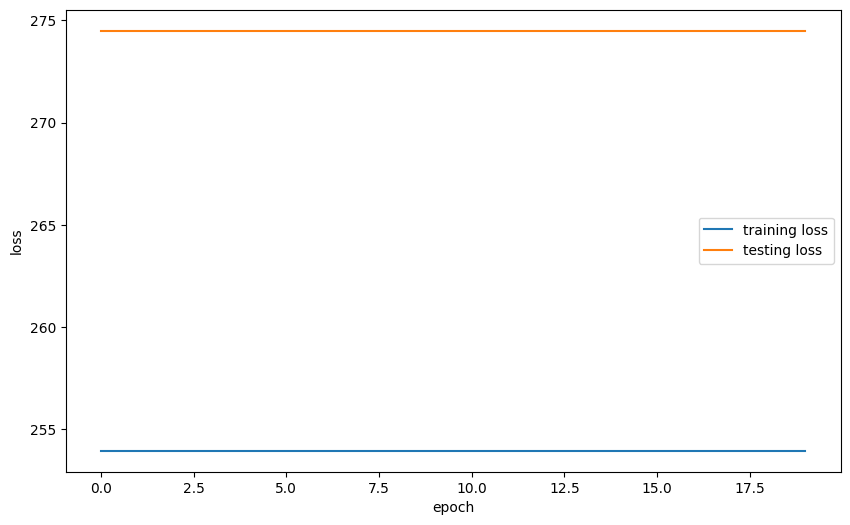

In [19]:
plot_loss_curve(training_loss_list, testing_loss_list)

通过打印损失的信息我们可以看到损失值持续上升，这就说明哪里出了问题。但是如果所有的测试样例都通过了，就说明我们的实现是没有问题的。运行下面的测试样例，观察哪里出了问题。

In [20]:
# 测试样例
Wt, bt = initialize(trainX.shape[1])
print('epoch 0, W:', Wt)  # [-0.00348894  0.00983703  0.00580923]
print('epoch 0, b:', bt)  # [ 0.]
print()

Zt = forward(trainX, Wt, bt)
dWt, dbt = compute_gradient(trainX, Zt, trainY)
print('dWt:', dWt) # [ -4.18172940e+09  -2.19880296e+08  -1.94481031e+08]
print('db:', dbt) # -364308.555764
print()

update(dWt, dbt, Wt, bt, 0.01)
print('epoch 1, W:', Wt)  # [ 41817293.96016914   2198802.97412493   1944810.31544994]
print('epoch 1, b:', bt)  # [ 3643.08555764]

epoch 0, W: [-0.00348894  0.00983703  0.00580923]
epoch 0, b: [0.]

dWt: [-2564.00248557  -379.32748793  -452.31925661]
db: -14.969203599190442

epoch 1, W: [25.63653591  3.80311191  4.52900179]
epoch 1, b: [0.14969204]


可以看到，我们最开始的参数都是在 $10^{-3}$ 这个数量级上，而第一轮迭代时计算出的梯度的数量级在 $10^8$ 左右，这就导致使用梯度下降更新的时候，让参数变成了 $10^6$ 这个数量级左右（学习率为0.01）。产生这样的问题的主要原因是：我们的原始数据 $X$ 没有经过适当的处理，直接扔到了神经网络中进行训练，导致在计算梯度时，由于 $X$ 的数量级过大，导致梯度的数量级变大，在参数更新时使得参数的数量级不断上升，导致参数无法收敛。

解决的方法也很简单，对参数进行归一化处理，将其标准化，使均值为0，缩放到 $[-1, 1]$附近。

## 10. 标准化处理

标准化处理和第一题一样

In [21]:
from sklearn.preprocessing import StandardScaler
stand = StandardScaler()
trainX_normalized = stand.fit_transform(trainX)
testX_normalized = stand.transform(testX)

重新训练模型，这次我们迭代40轮，学习率设置为0.1

In [22]:
m = trainX.shape[1]
W, b = initialize(m)
training_loss_list, testing_loss_list = train(trainX_normalized, trainY, testX_normalized, testY, W, b, 40, learning_rate = 0.1, verbose = False)

打印损失值变化曲线

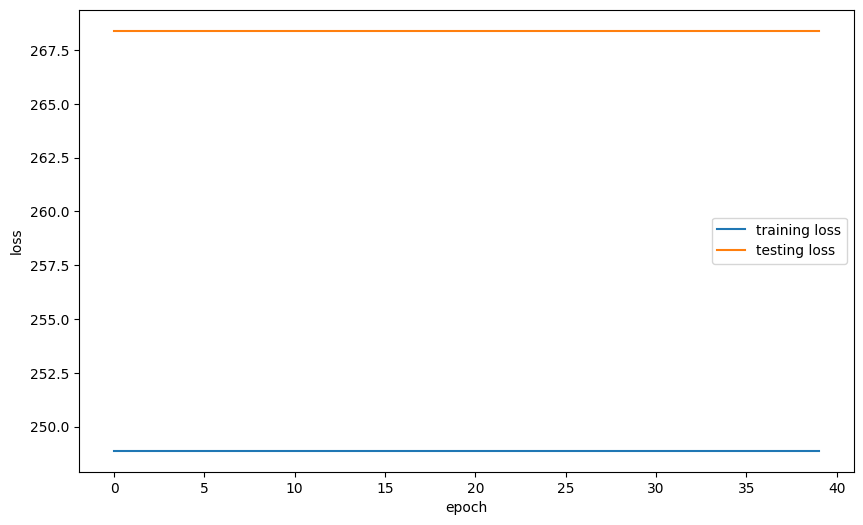

In [23]:
plot_loss_curve(training_loss_list, testing_loss_list)

计算测试集上的MSE

In [24]:
prediction = forward(testX_normalized, W, b)
mse(testY, prediction) ** 0.5

16.382758798844396